#  U1-Class 02:   Lab Exercise 2

### Optical flow Templates:  for Action Classification

**Description:**
In this laboratory exercise, we will explore how different human actions can be classified solely based on dense optical flow. As we discussed in class, the spatio-temporal distribution of these optical flow maps at each point in time is unique and can be visualized as a trajectory of causally connected points in a high-dimensional space. By applying dimensionality reduction techniques such as PCA or kernel-PCA, we can transform these trajectories into a lower-dimensional space where trajectories for the same action tend to have similar behavior. Using these transformed trajectories, we can classify human actions based on their similarity in the PCA space.


###  Figure of "optical flow trajectories"

The plot below shows two actions, each of which has its optical flow from each frame of the video (i.e., image sequence) projected into a PCA space. In this plot, each point represents an entire image (i.e., optical flow image) that is causally connected to the other points forming the trajectory.

#### Observations: 


- **The trajectories appear to be circular loops:** This is because the motion in human actions is often repetitive, as in the case of walking.

- **The entire image is projected onto a 3D point:** PCA is essentially a basis transformation that selects the largest basis vectors (i.e., the principal components). Therefore, even though we only visualize three dimensions, the size of the space is as large as each image, which is $n \times m$.


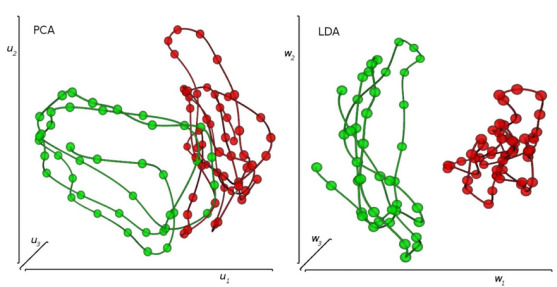

## Creating the templates

The following image shows how a frame in an image is used to create its corrsponding optical flow map.

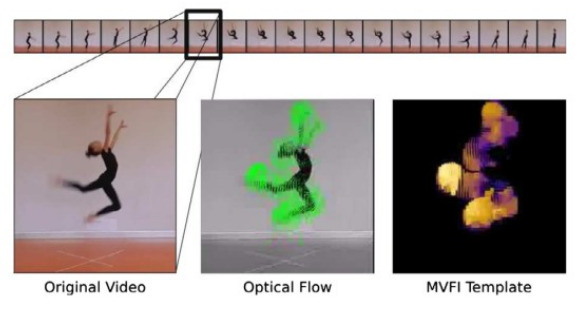

## Classification

The image below summarizes a typical Supervised Machine Learning situation with training and prediction based upon these templates.

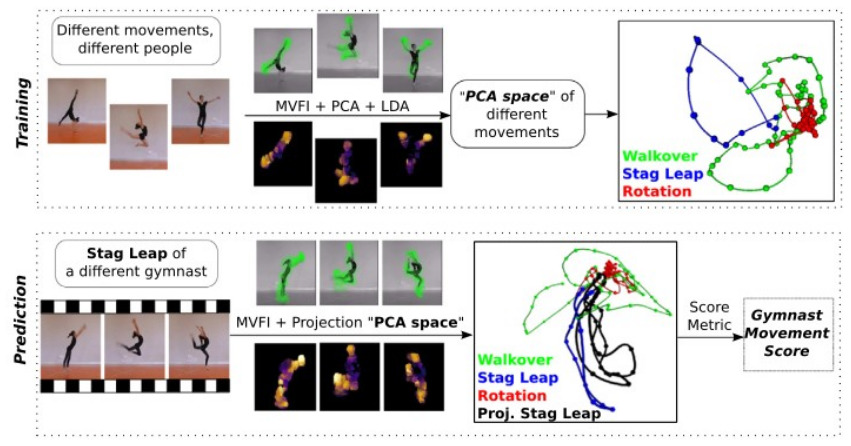

### CODE for producing optical flow with MVFI

###  The Code to produce the Optical flow template


In this  "demo" you will use a homegrown dataset that can be used to classify actions. Of course, it cannot compete with modern Deep Learning techniques,  however it can be useful in the following situations:

- **Similarity:**  How close is one action to another  (an automatic judge;  see the paper "Automatic recognition and scoring of olympic rhythmic gymnastic movements"
- **Simple detector:** A very simple classifier without extensive training could be used for detecting anomalous events:  "Eigenspace-based fall detection and activity recognition from motion templates and machine learning"
- **Determine exactly the degree of movement difference:** see  A KPCA spatio-temporal differential geometric trajectory cloud classiﬁer for recognizing human actions in a CBVR system

These are quite old papers, but they do demonstrate the method that is coded below.  

**Note:**  The code below is a very simplified version of that appearing in the papers above,  but serves to illustrate the concepts. 



## Instructions:

You must run the OpticalFlow code below for at least 3 actions before running the PCA.  When you run the Optical flow code, it will produce images in the corresponding directory of ./actiondata/images/.    To run another action, the videos are under ./actiondata/videos/A1  -- ./actiondata/videos/A7.

For example: 
```
capture =  './actiondata/videos/A1/P1/s1.avi'
output_dir = "./actiondata/images/A1/P1_1"
```
To add another action, just change ``A1--> A2`,  for example.


In [ ]:
#!/usr/bin/env python
##   Optical Flow Classification Code Demo
##   Uses python bindings to OpenCV for producing maps.
##
##   usage: 
##     ./soptflow.py <video_file>  <fillsquares> <vec_weight>
##
##   ejemplo:
##     ./soptflow.py ivan02.avi  1  10 5
##
##./soptflow.py videos/A1/P1/s1.avi  1  10 5 images/A1/P1_1

import sys,os
import cv2  
import numpy as np

class FBackMVFITemplates:
    def __init__(self, vidfile,  fillsquares, vec_weight, square_mult, output_dir):
        self.capture = cv2.VideoCapture(vidfile)      
        self.fillsquares = int(fillsquares)
        self.vec_weight = int(vec_weight)
        self.square_mult = int(square_mult)
        self.mv_step = 8
        self.mv_scale = 1.5
        self.mv_color = (0, 255, 0)
        self.cflow = None
        self.sflow = None
        self.flow = None
        self.frame_count = 0
        self.output_dir =  output_dir
        
        os.makedirs(self.output_dir, exist_ok=True)
        fps = self.capture.get(cv2.CAP_PROP_FPS)

        self.frame_size = (100, 100)
        ret, frame = self.capture.read()
        if ret:
            self.frame_size = (frame.shape[1], frame.shape[0])

        print(fps, self.frame_size)
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.cwriter = cv2.VideoWriter(self.output_dir + "/cflow.avi", fourcc, fps, self.frame_size, True)
        self.swriter = cv2.VideoWriter(self.output_dir + "/sflow.avi", fourcc, fps, self.frame_size, True)

        self.sflow = np.zeros((self.frame_size[1], self.frame_size[0], 3), dtype=np.uint8)
        #cv2.namedWindow("Optical Flow", cv2.WINDOW_NORMAL)

    def draw_flow(self, flow, prevgray):

        # print flow.height, flow.width
        self.cflow = cv2.cvtColor(prevgray, cv2.COLOR_GRAY2BGR)
        self.cflow = np.zeros_like(prevgray)
        self.sflow = np.zeros((prevgray.shape[0], prevgray.shape[1], 3), dtype=np.uint8)
        for y in range(0, flow.shape[0], self.mv_step):
            for x in range(0, flow.shape[1], self.mv_step):
                fx, fy = flow[y, x]
                if fx * fx + fy * fy > 4:
                    print(x, y, fx * fx + fy * fy)
                    cv2.line(self.cflow, (x, y), (x + int(fx), y + int(fy)), self.mv_color, 1, cv2.LINE_AA)
                    # Circle(self.cflow, (x,y), 2, self.mv_color, -1)
                    pt = []
                    dx = int(x + self.square_mult * fx)
                    dy = int(y + self.square_mult * fy)
                    print("points:", dx, dy)
                    pt.append((x, y))
                    pt.append((dx, y))
                    pt.append((dx, dy))
                    pt.append((x, dy))
                    if self.fillsquares:
                        buf = []
                        for i in range(len(pt)):
                            buf.append(pt[i])
                        cbar = self.vec_weight * round(np.sqrt(fx * fx + fy * fy))
                        # here is to generate a pseudocolor image...
                        gray  = cbar / 255.0
                        red   = round(255 * np.fabs(np.sin(gray * 2 + 0.0 * np.pi)))
                        green = round(255 * np.fabs(np.sin(gray * 2 - 0.1 * np.pi)))
                        blue  = round(255 * np.fabs(np.sin(gray * 2 - 0.3 * np.pi)))
                        cv2.fillConvexPoly(self.sflow, np.array(buf), (red, green, blue), cv2.LINE_AA, 0)
                    else:
                        cv2.rectangle(self.sflow, pt[1], pt[3], 50 * round(fx * fx + fy * fy), -1)

                    # so that it comes out in gray:
        cv2.imshow("Flow", self.sflow)
        cv2.imshow("Optical Flow", self.cflow)
                    
    
        # Check the length of self.frame_count and pad with zeros accordingly
        if self.frame_count < 10:
            padded_frame_count = f"000{self.frame_count}"
        elif self.frame_count < 100:
            padded_frame_count = f"00{self.frame_count}"
        elif self.frame_count < 1000:
            padded_frame_count = f"0{self.frame_count}"
        else:
            padded_frame_count = f"{self.frame_count}"

        filename = f"{self.output_dir}/frame_{padded_frame_count}.png"
        
        cv2.imwrite(filename, self.sflow)
        self.cwriter.write(self.cflow)
        self.swriter.write(self.sflow)
        self.frame_count += 1

    def run(self):
        first_frame = True
        ix = 0
        while True:
            ret, frame = self.capture.read()
            print(ix, "-----")
            if ret:
                if first_frame:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    flow = np.zeros_like(frame)
                    self.cflow = np.zeros_like(frame)

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                if not first_frame:
                    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, flow,
                                                        pyr_scale=0.5, levels=3, winsize=15,
                                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

                    self.draw_flow(flow, prev_gray)
                    c = cv2.waitKey(7)
                    if c in [27, ord('q'), ord('Q')]:
                        break

                prev_gray = gray
                ix = ix + 1
                first_frame = False
            else:
                break
                
            k = cv2.waitKey(30) & 0xff
            if k == 27:
                break
        # Release video capture and close windows
        self.capture.release()
        cv2.destroyAllWindows()

In [ ]:
#  The structure of the directory  ./actiondata/video/<action-label>/<person-label>/<videoshot>
#     where the action-label= A1, ... A7;   person-label= P1
capture =  './actiondata/videos/A1/P1/s1.avi'
fillsquares = 1
vec_weight = 10
square_mult = 5
output_dir = "./actiondata/images/A1/P1_1"

M = FBackMVFITemplates(capture, fillsquares, vec_weight, square_mult, output_dir)
M.run()

### The PCA/LDA code.

In [ ]:
#!/usr/bin/env python
"""
classify optical flow templates with PCA and LDA:

PCA is an unsupervised dimensionality reduction technique that doesn't take class 
labels into account. To achieve maximal separation between classes (like Fisher's criterion), 
you can use Linear Discriminant Analysis (LDA) instead, which is a supervised technique.

The PCA method can take class labels into account, considering the following general procedure:
    1.  Perform LDA on the dataset to maximize between-class scatter and minimize within-class scatter.
    2.  Apply PCA on the LDA-transformed dataset to further reduce the dimensionality.


Here, we follow this two-step approach of LDA followed by PCA, by using the steps below:
    1. Import the necessary libraries.
    2. Load and preprocess images.
    3. Flatten the images.
    4. Perform LDA on the dataset.
    5. Apply PCA on the LDA-transformed dataset.
    6. Perform analysis using the PCA-transformed data.
"""

import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def load_images_from_directory(directory_path, target_size=(100, 100)):
    images = []
    labels = []
    for action_dir in os.listdir(directory_path):
        action_path = os.path.join(directory_path, action_dir)
        if os.path.isdir(action_path):
            for sequence_dir in os.listdir(action_path):
                sequence_path = os.path.join(action_path, sequence_dir)
                if os.path.isdir(sequence_path):
                    for file in os.listdir(sequence_path):
                        if file.endswith((".jpg", ".jpeg", ".png")):
                            img = cv2.imread(os.path.join(sequence_path, file), cv2.IMREAD_GRAYSCALE)
                            img = cv2.resize(img, target_size)
                            images.append(img)
                            labels.append(action_dir)
    return images, labels

def flatten_images(images):
    return [img.flatten() for img in images]


def plot_pca_lda(pca_data, lda_data, labels):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
    axes[0].set_title('PCA')
    axes[1].scatter(lda_data[:, 0], lda_data[:, 1], c=labels, cmap='viridis')
    axes[1].set_title('LDA')
    plt.show()

def plot_3d_pca(pca_data, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = list(set(labels))
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        ax.scatter(pca_data[indices, 0], pca_data[indices, 1], pca_data[indices, 2], c=[color], label=label)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    plt.show()



def analysis_pca(X_train, y_train):
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(X_train)
    print(pca_data.shape)
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(X_train)
    plot_3d_pca(pca_data, y_train)

def analysis_pca_lda(X_train, y_train):
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(X_train)
    print(pca_data.shape)
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(X_train)
    lda = LDA(n_components=2)
    lda_data = lda.fit_transform(X_train, y_train)
    print(lda_data.shape)
    print(lda_data)
    plot_pca_lda(pca_data, lda_data, y_train) 


def analysis_kernelpca(X_train, y_train):
    # Preprocess the data using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # Perform Kernel PCA with 3 components and an RBF kernel
    # kernel: 'linear', 'poly', 'sigmoid', 'rbf'
    # gamma parameter can be adjusted as needed
    kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.1)  
    kpca_data = kpca.fit_transform(X_train_scaled)
    plot_3d_pca(kpca_data, y_train)


if __name__ == "__main__":
    directory_path = "./actiondata/images"
    target_size = (100, 100)
    num_components=2
    images, labels = load_images_from_directory(directory_path, target_size)
    feature_vectors = flatten_images(images)
    X_train = feature_vectors
    y_train = int_labels = [int(label[1:]) for label in labels]
    lda = LDA()
    X_lda = lda.fit_transform(X_train, y_train)
    pca = PCA(n_components=num_components)   
    X_pca = pca.fit_transform(X_lda)
    analysis_kernelpca(X_pca, y_train)
    

# Exercises  Lab02



### Objective:  

- The purpose of the lab is to gain intuition of optical flow algorithms by using OpenCV with human action application. 

- The lab is limited in scope and does not require training/testing a classifier.   It only requires that you run the code provided in the notebook and change parameters to observe the output.   

- This is a brief exercise;  some (or most) of which could possibly be completed with the lab period.   Your descriptions should be concise and not require a lengthy report. The exercise involves testing the code, making observations, and experimenting with minor changes to input parameters or optical flow algorithm choices.


### Submission: 

- The lab exercise consists of performing the following tasks The percentage of the points assigned to the lab exercise is given for each point.

- The submission should be in the form of a PDF file of your Jupyter Notebook output.


### The Exercise


You should complete the following tasks (percent of the total notebook exercise grade is indicated).  


1.  (10%) **Understanding the code:** Review the code provided and explain each part of the code in your own words. The descriptions should be brief (maximum two sentences) and doesn't have to explain every line; it should be sufficiently succinct to show that you understand the code and what it does.

2. (10% ) **Testing with provided datasets:** To further explore the use of human actions, you can either use the videos provided in the dataset or find other videos of human actions. Once you have these new videos, you should re-run the code provided above and analyze the PCA projection results. During the analysis, you should observe which actions or situations lead to optical flow maps and trajectories that are clearly separated.

3. (20%) **Identifying strengths and weaknesses:** After completing the analysis of the PCA projection results, you should describe the strengths and weaknesses of the optical flow method based on your observations. Consider the following factors: the types of actions performed in the videos, the quality of the videos, the lighting conditions of the videos, and the complexity of the backgrounds in the videos. Describe how each of these factors could affect the algorithm's performance, including how they might impact the accuracy of the motion estimation or the robustness of the algorithm in handling different types of actions or backgrounds.

4. (40%) **Changing/Improving the algorithm:**  Propose  ONE  modification to the existing optical flow algorithm code that could potentially improve its performance. This could involve adjusting the optical flow parameters or changing the algorithm itself. Other potential modifications could include preprocessing the video frames for the templates, such as resizing, denoising, or background subtraction, or using a different method for binarizing the optical flow maps. Be sure to explain why you are making this change and how it could improve the algorithm's performance.

5. (20%) **Observing the improvements (if any):** Once you have implemented your modifications to the optical flow algorithm code, you should test the code that produces the PCA projections and compare the new results with the original ones. You can do this by observing the optical flow frames and/or the resulting separation between LDA/PCA trajectories for each action. After comparing the results, you should briefly comment on the following:
- Did the modifications lead to an improvement in representing the movement in the video with the optical flow maps? This assessment will be qualitative.
- How did the modifications affect the performance of the LDA/PCA projection and the resulting 3D trajectories? This can be described intuitively or by observation, and should provide insight into how the modifications affected the accuracy or robustness of the algorithm.


### Submission

You should submit the lab exercise on the online platform of your university in the form of a jupyter notebook.  


Due date:    10/04/2023




##  Optional  (not required for submission)

6. **Optional extension:** If you wanted to understand more details, the point of this code would be to explore the classification aspect of the method. For those interested,  in order to understand what would be involved, you could implement the following: 
- setup a problem of supervised learning by dividing the dataset into test/train
- select a classifier method or try various: (e.g., k-Nearest Neighbors or Support Vector Machines) to classify the human actions in the video datasets based on the 3D trajectories. 
- Use to classifier to predictions of an should evaluate its performance using appropriate evaluation metrics (e.g., accuracy, precision, recall, F1 score) and discuss any challenges or limitations they encountered.
- Could you use this technique to detect small difference of movement even with the same action?
